<a href="https://colab.research.google.com/github/Baibhav-Mishra/SudokuSolver/blob/main/Sudoku_Solver_OpenCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Sudoku Solver

def find_empty(board):
    """returns the first empty block"""
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                return (i, j)  # row, col

    return None

def valid(board, num, pos):
    """returns true if the num at pos is valid"""
    # Check row
    for i in range(9):
        if board[pos[0]][i] == num and pos[1] != i:
            return False

    # Check column
    for i in range(9):
        if board[i][pos[1]] == num and pos[0] != i:
            return False

    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if board[i][j] == num and (i,j) != pos:
                return False

    return True


def solve(board):
    """Takes a unsolved sudoku board and solves it if it is solvable and returns True"""
    find = find_empty(board)
    if not find: # no empty blanks left
        return True
    else:
        row, col = find

    for i in range(1,10):
        if valid(board, i, (row, col)):
            board[row][col] = i

            if solve(board): # recursively go inside and assign a valid number to next blank
                return True
            board[row][col] = 0 # backtrack and set 0 if solve for new config is False

    return False # no valid number possible for blank


def get_board(bo):
    """Takes a 9x9 matrix unsolved sudoku board and returns a fully solved board."""
    if solve(bo):
        return bo
    else:
        print("Unsolvable configuration")
        raise ValueError


In [2]:
# OpenCV utils

def get_perspective(img, location, height = 900, width = 900):
    """Takes an image and location os interested region.
        And return the only the selected region with a perspective transformation"""
    pts1 = np.float32([location[0], location[3], location[1], location[2]])
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(img, matrix, (width, height))
    return result

def get_InvPerspective(img, masked_num, location, height = 900, width = 900):
    """Takes original image as input"""
    pts1 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    pts2 = np.float32([location[0], location[3], location[1], location[2]])

    # Apply Perspective Transform Algorithm
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    result = cv2.warpPerspective(masked_num, matrix, (img.shape[1], img.shape[0]))
    print("Inverse perspective of solution mask:")
    cv2_imshow(result)
    return result


def find_board(img):
    """Takes an image as input and finds a sudoku board inside of the image"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    bfilter = cv2.bilateralFilter(gray, 13, 20, 20)
    edged = cv2.Canny(bfilter, 30, 180)
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours  = imutils.grab_contours(keypoints)

    newimg = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 3)
    print("\nDetected contours:")
    cv2_imshow(newimg)


    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15] # top 15 largest countours
    location = None

    # Finds rectangular contour
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 15, True)
        if len(approx) == 4:
            location = approx
            break
    result = get_perspective(img, location)
    print("\nCropped board:")
    cv2_imshow(result)
    return result, location


# split the board into 81 individual images
def split_boxes(board):
    """Takes a sudoku board and split it into 81 cells.
        each cell contains an element of that board either given or an empty cell."""
    rows = np.vsplit(board,9)
    boxes = []
    print("\nSplit boxes:")
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            box = cv2.resize(box, (input_size, input_size))/255.0
            cv2_imshow(box*255)
            # cv2.waitKey(50)
            boxes.append(box)
    cv2.destroyAllWindows()
    return boxes

def displayNumbers(img, numbers, color=(0, 255, 0)):
    """Displays 81 numbers in an image or mask at the same position of each cell of the board"""
    W = int(img.shape[1]/9)
    H = int(img.shape[0]/9)
    for i in range (9):
        for j in range (9):
            if numbers[(j*9)+i] !=0:
                cv2.putText(img, str(numbers[(j*9)+i]), (i*W+int(W/2)-int((W/4)), int((j+0.7)*H)), cv2.FONT_HERSHEY_COMPLEX, 2, color, 2, cv2.LINE_AA)
    print("\nSolved board masked:")
    cv2_imshow(img)
    return img


Detected contours:


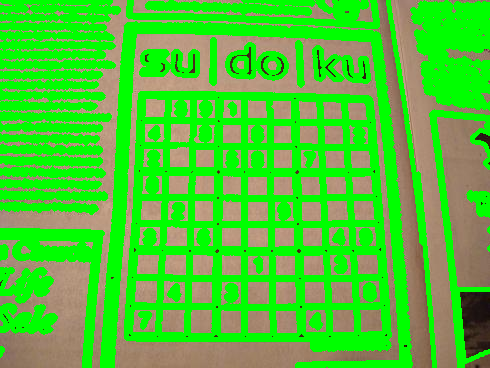


Cropped board:


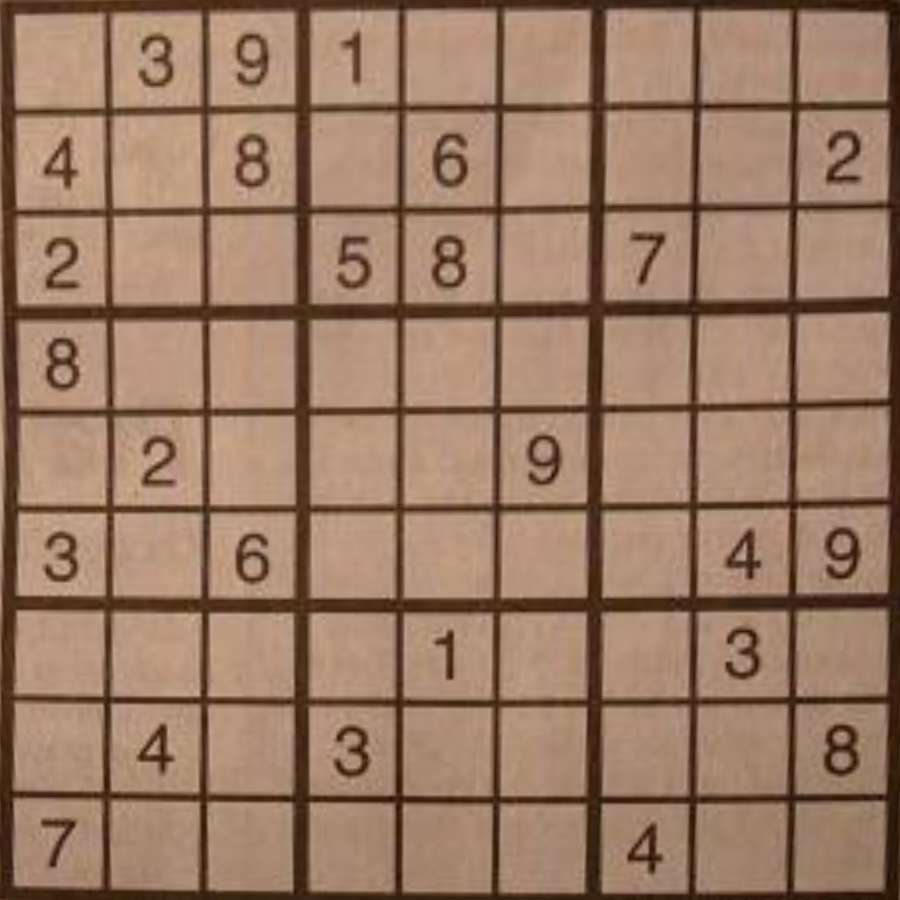


Split boxes:


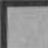

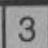

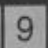

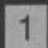

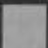

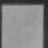

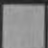

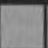

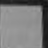

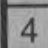

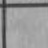

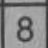

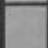

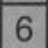

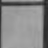

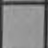

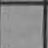

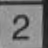

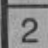

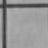

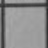

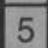

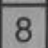

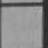

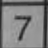

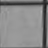

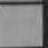

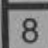

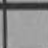

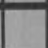

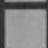

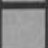

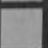

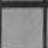

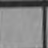

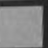

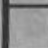

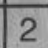

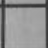

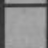

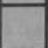

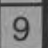

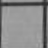

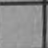

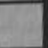

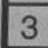

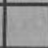

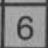

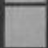

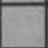

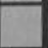

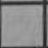

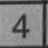

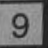

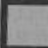

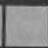

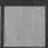

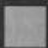

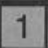

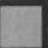

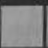

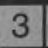

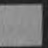

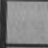

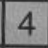

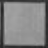

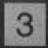

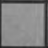

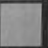

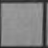

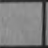

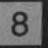

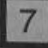

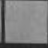

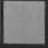

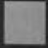

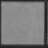

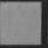

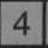

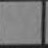

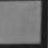

3/3 [==============================] - 3s 156ms/step

Board configuration matrix:
 [[0 3 9 1 0 0 0 0 0]
 [4 0 8 0 6 0 0 0 2]
 [2 0 0 5 8 0 7 0 0]
 [8 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 9 0 0 0]
 [3 0 6 0 0 0 0 4 9]
 [0 0 0 0 1 0 0 3 0]
 [0 4 0 3 0 0 0 0 8]
 [7 0 0 0 0 0 4 0 0]]

Solved board masked:


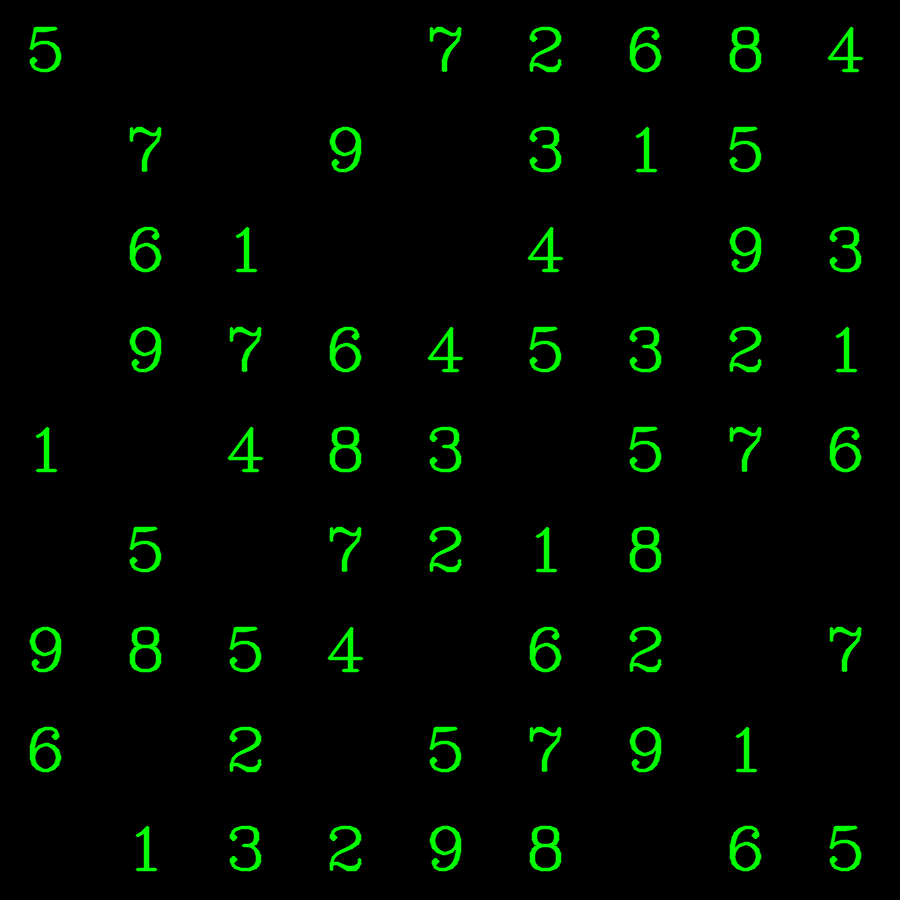

Inverse perspective of solution mask:


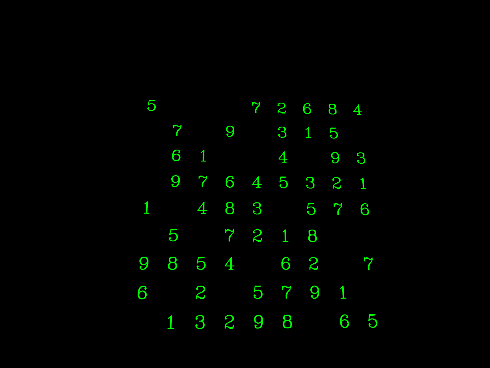


Final solved image:


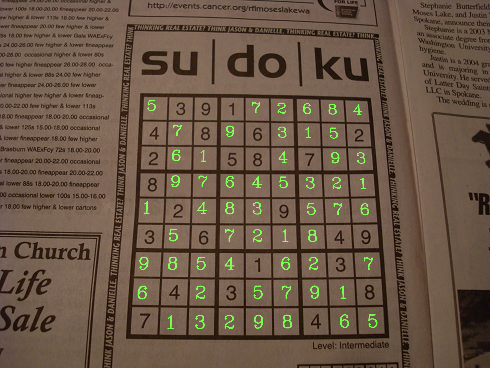

In [4]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import imutils
from google.colab.patches import cv2_imshow

model = load_model('model-OCR.h5')

input_size = 48

# Read image from path
img = cv2.imread('sudoku1.jpg')

# extract board and its location from input image
board, location = find_board(img)

# extract individual blocks from board
gray = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
rois = split_boxes(gray)
rois = np.array(rois).reshape(-1, input_size, input_size, 1) # (batchsize, H, W, C)

# get prediction
prediction = model.predict(rois)

predicted_numbers = []
for i in prediction: # get classes from prediction
    predicted_numbers.append(np.argmax(i)) # appends the index of the maximum number of the array

# reshape the list
board_config = np.array(predicted_numbers).astype('uint8').reshape(9, 9)
print("\nBoard configuration matrix:\n", board_config)

# solve the board
try:
    solved_board_config = get_board(board_config)
    # print("Solved board nums:\n", solved_board_config)

    # create a binary array of the predicted numbers. 0 if given 1 if blank
    binArr = np.where(np.array(predicted_numbers)>0, 0, 1) # (condition, true, false)

    # get only solved numbers for the blanks
    flat_solved_board_config = solved_board_config.flatten()*binArr
    # print("Flat solved board nums:\n", flat_solved_board_config)

    # create a mask image in dims of board
    mask = np.zeros_like(board)
    # displays solved numbers in the mask in the same position where board numbers are empty
    solved_board_mask = displayNumbers(mask, flat_solved_board_config)

    inv = get_InvPerspective(img, solved_board_mask, location)

    combined = cv2.addWeighted(img, 0.7, inv, 1, 0)
    print("\nFinal solved image:")
    cv2_imshow(combined)
    # cv2.waitKey(0)


except:
    print("Solution doesn't exist")

# cv2_imshow(img)
# cv2.imshow(board)
cv2.waitKey(0)
cv2.destroyAllWindows()